In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import FinanceDataReader as fdr
import yfinance as yf
import numpy as np

import datetime as dt

In [3]:
import scipy.optimize as sco

In [4]:
# 시각화 관련
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

In [5]:
# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
# px를 쉽고 빠르게 붙여주는 모듈 cufflinks
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')

import plotly.graph_objects as go

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
%run ../library/QUANT_FUNCTIONS.ipynb
Q = QUANT()
D = DATA()

###### 공통함수

In [7]:
## 수치형 데이터프레임을 시작점기준으로 지수화
def index_values(orgin_df):
    df = orgin_df.copy()
    for i in df.columns:
        if (df[i].dtype == float)|(df[i].dtype == int):
            df[i] = df[i]/df[i][0]
        else:
            df[i] = df[i]
    return df

###### 데이터 불러오기

In [8]:
AWP_result = pd.read_csv('result/AWP_result.csv', index_col='Date')
VAA_result = pd.read_csv('result/VAA_result.csv', index_col='Date')

df = pd.DataFrame(index=AWP_result.index)
df['AWP'] = AWP_result['strategy']
df['VAA'] = VAA_result['strategy']

df = df.dropna()

## 백데이터 기간 지정(12개월)
## df = df.iloc[-24:]

In [9]:
## 지수화
df = index_values(df)

df.index = pd.to_datetime(df.index)

In [10]:
## 월단위 변환 함수
def day_to_mth(dataset):
    df = dataset.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    ## df = df[df['day']>=24]

    df = df.drop_duplicates(['year', 'month'], keep='last')
    df = df.drop(columns=['year', 'month', 'day'])
    return df

In [11]:
bm_temp = D.get_merged_df('SPY')

In [14]:
Trading_result = pd.read_csv('result/비정형트레이딩_1등주매수전략.csv', index_col='tdate')
Trading_result.index.name = 'Date'
Trading_result.index = pd.to_datetime(Trading_result.index)
Trading_result = day_to_mth(Trading_result)
Trading_result['result'][0] = 1

In [15]:
Trading_result.index = ['2019-01-31', '2019-02-28', '2019-03-29', '2019-04-30',
               '2019-05-31', '2019-06-28', '2019-07-31', '2019-08-30',
               '2019-09-30', '2019-10-31', '2019-11-29', '2019-12-31',
               '2020-01-31', '2020-02-28', '2020-03-31', '2020-04-30',
               '2020-05-29', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-30', '2020-11-30', '2020-12-31',
               '2021-01-29', '2021-02-26', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-23']

Trading_result.index = pd.to_datetime(Trading_result.index)

In [16]:
bm_temp = D.get_merged_df('SPY')
bm_temp = day_to_mth(bm_temp)

df = pd.DataFrame(index=AWP_result.index)
df['AWP'] = AWP_result['strategy']
df['VAA'] = VAA_result['strategy']
df.index = pd.to_datetime(df.index)


df['TRD'] = Trading_result['result']
df['SPY'] = bm_temp['SPY']

df = df.dropna()


df = index_values(df)

In [17]:
# 시각화 관련
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

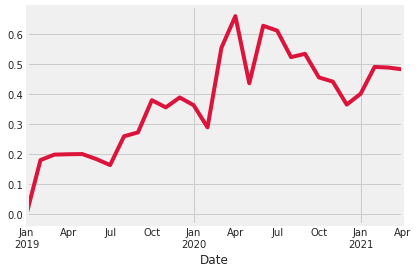

In [23]:
np.log(df[['TRD']]).plot(color=['crimson'], legend=False)

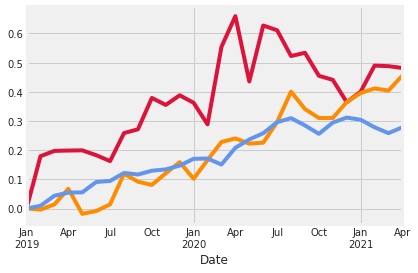

In [24]:
np.log(df[['TRD','VAA', 'AWP']]).plot(color=['crimson', 'darkorange', 'cornflowerblue'], legend=False)

In [256]:
Q.get_SRTR_report(df, 'a', unit='monthly')

,Ticker,YRR,YDD,Sortino Ratio
0,AWP,0.126721,0.036226,3.498116
1,VAA,0.215676,0.082488,2.614642
2,TRD,0.229179,0.171229,1.338431
3,SPY,0.226390,0.112220,2.017377


In [275]:
## 최대낙폭(MDD)
MDD, HRR = Q.get_MDD_report(df, 'a')
MDD

,Ticker,MDD,Date
0,AWP,-0.052363,2020-10-30
1,VAA,-0.086476,2020-10-30
2,TRD,-0.255371,2020-12-31
3,SPY,-0.194477,2020-03-31


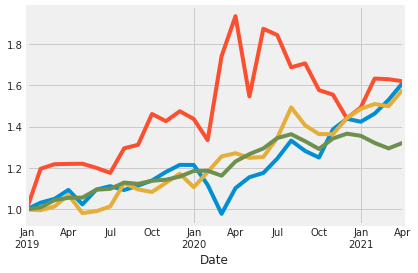

In [20]:
df[['SPY', 'TRD', 'VAA','AWP']].plot(legend=False)

In [277]:
df.iplot()

In [261]:
df['2020-01-01':'2020-04-30']

,AWP,VAA,TRD,SPY
Date,,,,
2020-01-31,1.185625,1.107263,1.436527,1.214471
2020-02-28,1.186702,1.180635,1.334141,1.118327
2020-03-31,1.162652,1.255920,1.739684,0.978680
2020-04-30,1.231320,1.271229,1.932904,1.102956


## 리벨런싱

In [10]:
def cal_AWP(df, ratio = [0.5, 0.5], rebalancing=None, unit = 'daily'):
    new_df = df.copy()
    ## rebalancing 'm'월, 'y'연, 
    df_dict = []
    ## 데이터 분할
    years = sorted(new_df.index.year.unique())
    months = sorted(new_df.index.month.unique())
    
    ## 가치변화 계산용(월단위 집계데이터로 계산할 때 발생하는 에러보정)
    if (rebalancing == 'm')&(unit == 'monthly'):
        temp_df = new_df.copy()
        temp_df.index = temp_df.index - dt.timedelta(days=1)
        new_df = new_df.append(temp_df)
        new_df = new_df.sort_index()
        new_df = new_df.shift(-1).dropna()
        
    if rebalancing == 'm' :
        for year in years:
            for month in months:
                temp = new_df[(new_df.index.year == year)&(new_df.index.month == month)]
                if len(temp) > 0:
                    df_dict.append(temp)
                    
    elif rebalancing == 'y':
        for year in years:
            temp = new_df[(new_df.index.year == year)]
            if len(temp) > 0:
                df_dict.append(temp)
    else:
        df_dict.append(new_df)
    ## 리벨런싱 적용
    prev_val = 1
    temp_series = pd.Series()
    for i in range(len(df_dict)):    
        temp = index_values(df_dict[i])
        temp_AWP = (temp * ratio).sum(axis=1)*prev_val
        prev_val = temp_AWP[-1]
        temp_series = temp_series.append(temp_AWP)
    new_df['strategy'] = temp_series
    
    ## 가치변화 계산용 임시 데이터프레임을 원래 형태로 되돌림
    if (rebalancing == 'm')&(unit == 'monthly'):
        new_df['temp_y'] = new_df.index.year
        new_df['temp_m'] = new_df.index.month
        new_df = new_df.drop_duplicates(['temp_y', 'temp_m'])
        new_df = new_df.drop(columns=['temp_y', 'temp_m'])
        new_df.index = df.index
    
    return new_df

## 최적화

In [11]:
def cal_optimal(df, df_unit='monthly', rebalancing = 'm'):
    ## df_unit 데이터 집계주기 : daily, monthly => 수익, 위험 연율화 계산에 사용
    ## rebalancing 리벨런싱 주기 : None, m, y
    pyrr = []     # 리스트 형태로 수익을 쌓을 장소
    pydd = []     # 리스트 형태로 위험(표준편차)을 쌓을 장소
    pstn = []
    weghs = []

    for p in range (1000):
        if p%25 == 0:
            print(f"{p}단계 진행중")
        weights = np.random.random(len(df.T))   # 랜덤한 n개의 숫자를 생성함(n개의 자산에 대응)
        weights /= np.sum(weights)     # n개의 숫자의 합계가 1이 되도록 조정함(각 자산의 비중)

        result_df = cal_AWP(df, weights, rebalancing=rebalancing, unit=df_unit)
        sortino = Q.get_SRTR_report(result_df, 'a', unit=df_unit)

        pyrr.append(sortino['YRR'][len(sortino)-1])
        pydd.append(sortino['YDD'][len(sortino)-1])
        pstn.append(sortino['Sortino Ratio'][len(sortino)-1])
        weghs.append(weights)

    pyrr = np.array(pyrr)
    pydd = np.array(pydd)
    pstn = np.array(pstn)
    weghs = np.array(weghs)

    process = pd.DataFrame(weghs, columns=df.columns)
    process['YRR'] = pyrr
    process['YDD'] = pydd
    process['Sortino Ratio'] = pstn
    
    obtimal = process[process['Sortino Ratio']==process['Sortino Ratio'].max()]
    obtimal = obtimal.reset_index(drop=True)
    min_risk = process[process['YDD']==process['YDD'].min()]
    min_risk = min_risk.reset_index(drop=True)

    return process, obtimal, min_risk

In [27]:
process, obtimal, min_risk = cal_optimal(df, df_unit='monthly', rebalancing = 'm')

0단계 진행중
25단계 진행중
50단계 진행중
75단계 진행중
100단계 진행중
125단계 진행중
150단계 진행중
175단계 진행중
200단계 진행중
225단계 진행중
250단계 진행중
275단계 진행중
300단계 진행중
325단계 진행중
350단계 진행중
375단계 진행중
400단계 진행중
425단계 진행중
450단계 진행중
475단계 진행중
500단계 진행중
525단계 진행중
550단계 진행중
575단계 진행중
600단계 진행중
625단계 진행중
650단계 진행중
675단계 진행중
700단계 진행중
725단계 진행중
750단계 진행중
775단계 진행중
800단계 진행중
825단계 진행중
850단계 진행중
875단계 진행중
900단계 진행중
925단계 진행중
950단계 진행중
975단계 진행중


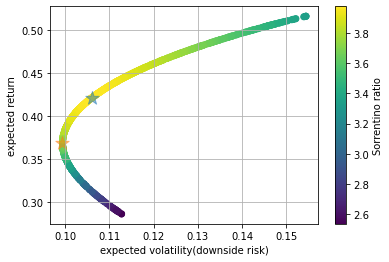

In [28]:
plt.scatter(process['YDD'], process['YRR'], c=process['Sortino Ratio'], marker='o')
plt.grid(True)
plt.xlabel('expected volatility(downside risk)')
plt.ylabel('expected return')
plt.colorbar(label='Sorrentino ratio')

plt.scatter(obtimal['YDD'][0], obtimal['YRR'][0], marker="*", s=200, alpha=0.5)
plt.scatter(min_risk['YDD'][0], min_risk['YRR'][0], marker="*", s=200, alpha=0.5)

plt.show()

In [29]:
obtimal

,AWP,VAA,YRR,YDD,Sortino Ratio
0,0.479644,0.520356,0.421367,0.106028,3.974112


## 활용 예시

###### 보고서

In [13]:
## 포트폴리오 결정
result_df = cal_AWP(df, list(obtimal.values[0][:-3]), rebalancing='m',unit='monthly')

In [14]:
## 연수익률(YTD)
Q.get_YTD_report(result_df, 'a')

,AWP,VAA,strategy
Date,,,
2011,0.357598,0.596422,0.519559
2012,0.254265,0.525176,0.413585
2013,0.176634,0.769990,0.468013
2014,0.541359,0.529271,0.541388
2015,0.034605,-0.157475,-0.055305
2016,0.075653,0.470826,0.275616
2017,0.476689,0.703381,0.594914
2018,-0.064696,0.343754,0.146231
2019,0.770816,0.624660,0.732396


In [31]:
Q.get_SRTR_report(df[16:-33], unit='monthly')

,Ticker,YRR,YDD,Sortino Ratio
0,AWP,0.057172,0.030861,1.852571
1,VAA,0.083996,0.058165,1.444114


In [15]:
## 최대낙폭(MDD)
MDD, HRR = Q.get_MDD_report(result_df, 'a')
MDD

,Ticker,MDD,Date
0,AWP,-0.221547,2018-12-31
1,VAA,-0.356894,2015-12-31
2,strategy,-0.234026,2020-10-30


In [16]:
## 리스크 대비 리턴(sortino ration)
Q.get_SRTR_report(result_df, 'a', unit='monthly')

,Ticker,YRR,YDD,Sortino Ratio
0,AWP,0.284110,0.114891,2.472862
1,VAA,0.516631,0.154512,3.343629
2,strategy,0.422396,0.106353,3.971626


In [21]:
beta

0.4982689695170962

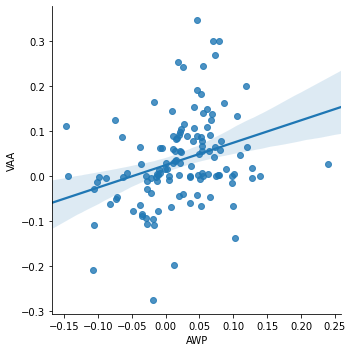

Corr: 0.31, Beta: 0.5


In [17]:
## 자산관계(corr, bata)

## 변동량 데이터구성
rets_origin = Q.get_rets_df(df)
## 상관계수
corr = rets_origin.corr()
corr = np.array(corr)[0, 1]
## 배타산출
beta = Q.cal_beta(rets_origin, "AWP", "VAA")

sns.lmplot(data = rets_origin, x='AWP', y='VAA')
plt.show()
print(f"Corr: {corr.round(2)}, Beta: {beta.round(2)}")

In [18]:
## odds(승률)
rets = Q.get_rets_df(result_df)
Q.get_odds_df(rets, 0.00165).round(2)

,odds
AWP,0.66
VAA,0.61
strategy,0.66


In [19]:
## 변동률 그래프
rets.iplot(kind='bar')

In [20]:
## 추세 그래프
result_df.iplot()